building kinetic matrix …
done.

==== Rc = 1.50 Å ====


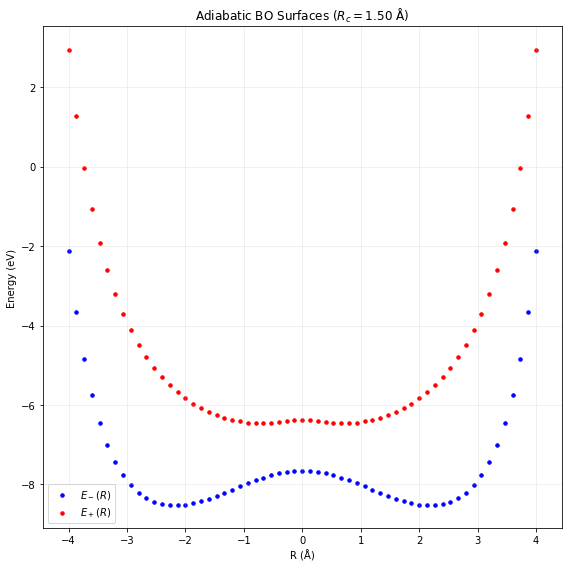

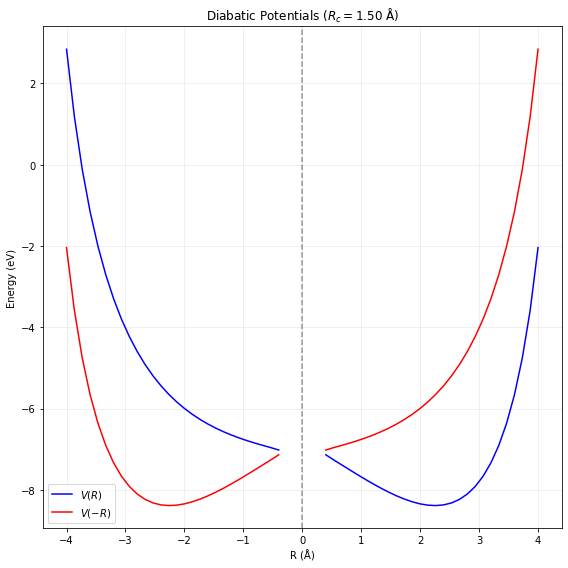

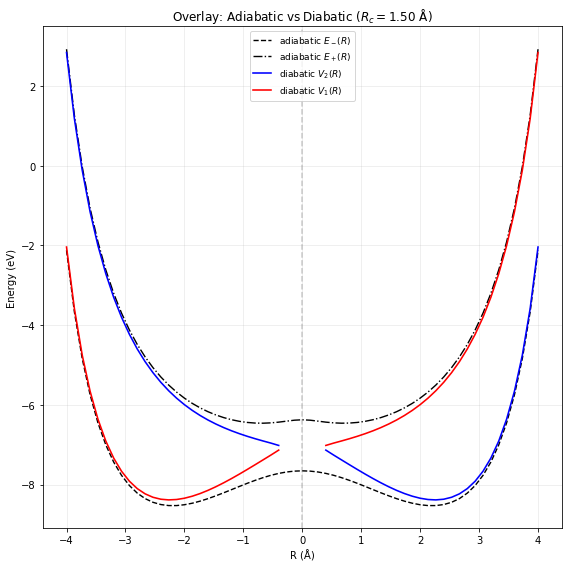

==== Rc = 1.75 Å ====


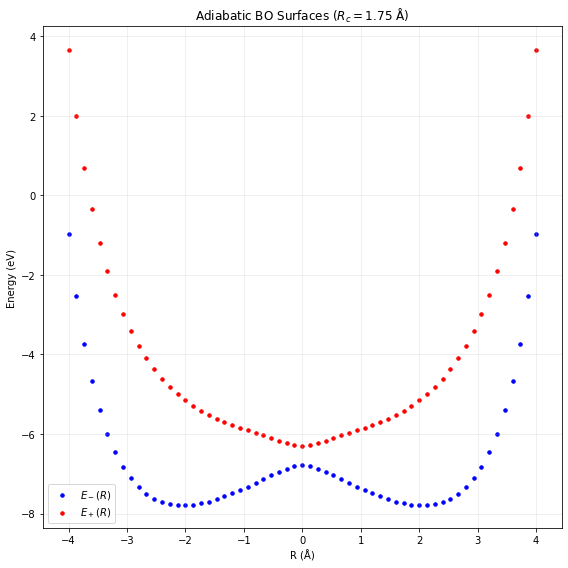

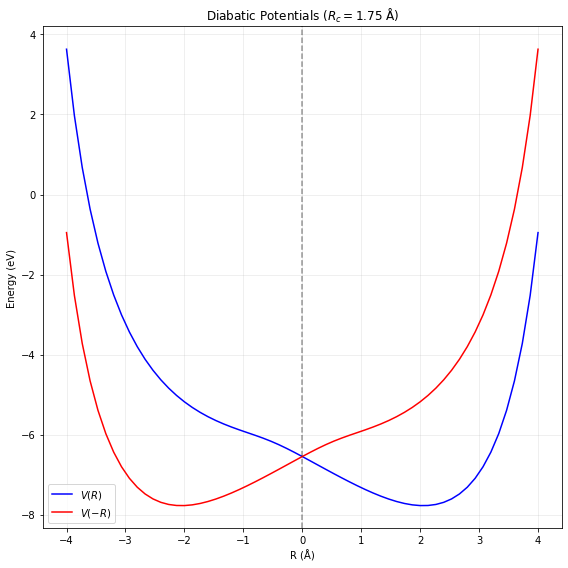

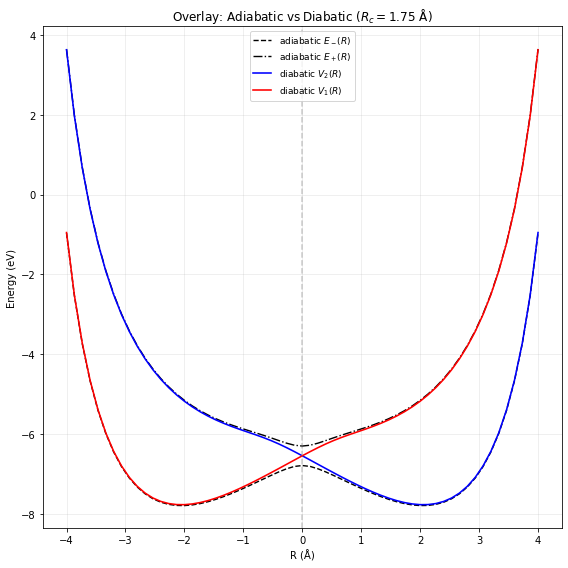

==== Rc = 2.00 Å ====


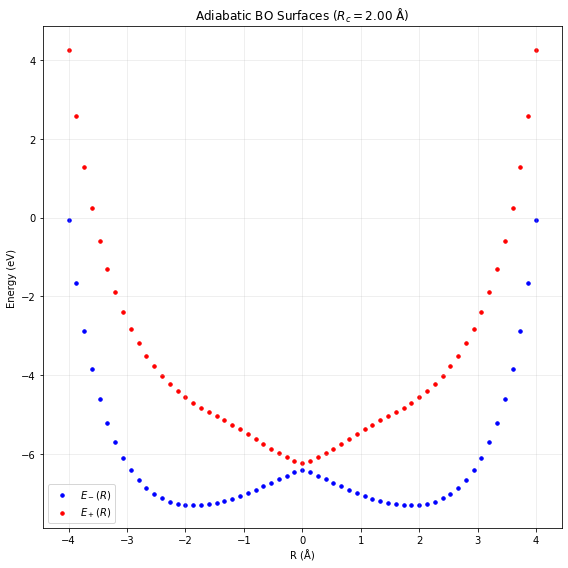

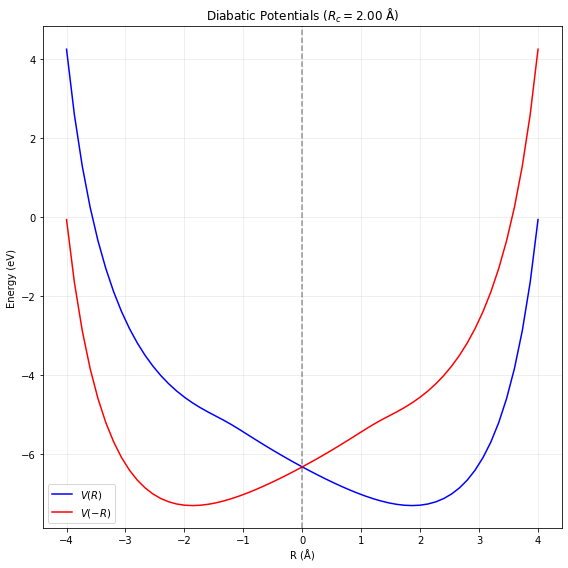

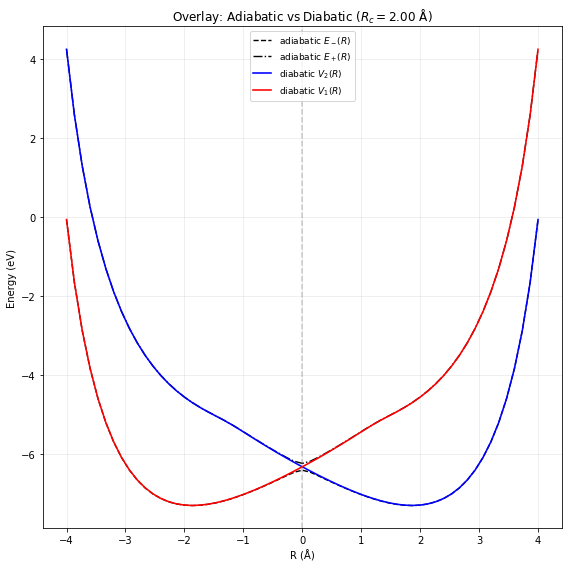

==== Rc = 2.50 Å ====


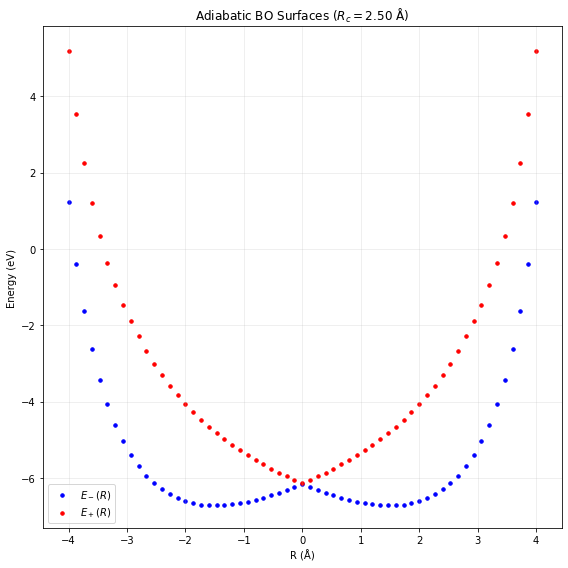

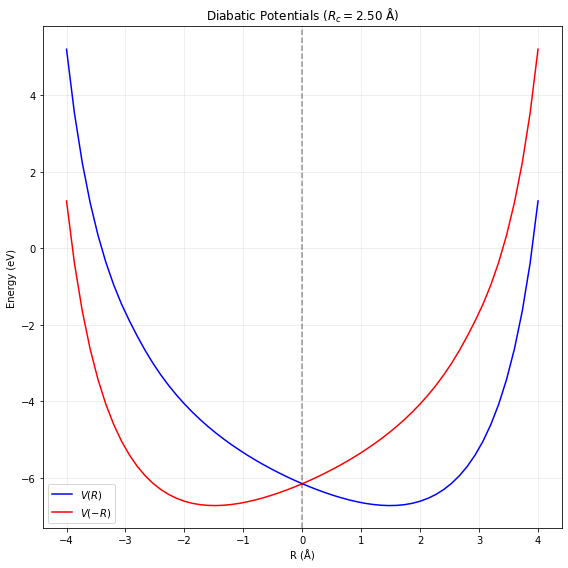

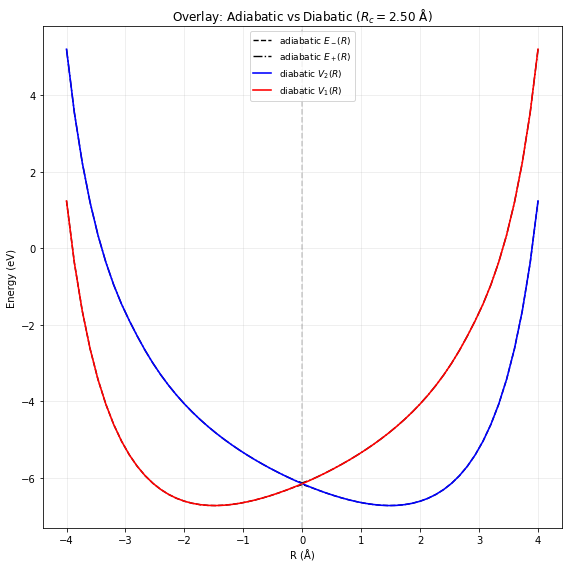

In [1]:
"""
Shin‑Metiu model: adiabatic–diabatic surfaces

Outputs (for each Rc):
1. scatter plot of adiabatic BO surfaces E_-(R), E_+(R)
2. line plot of diabatic V(R), V(-R)
3. overlay of adiabatic & diabatic surfaces
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import erf
import warnings
warnings.filterwarnings("ignore")

# ----------------- unit conversions -----------------
bohr_to_angstrom = 0.529177210903
angstrom_to_bohr = 1.0 / bohr_to_angstrom
hartree_to_eV     = 27.211386245988

# ----------------- grid & constants -----------------
N               = 1024               # FFT grid points
x_max_angstrom  = 10.0
x_max           = x_max_angstrom * angstrom_to_bohr
x               = np.linspace(-x_max, x_max, N)
dx              = x[1] - x[0]
K               = np.pi / dx         # Nyquist momentum

Z               = 1.0
Rc_vals_angstrom = [1.5, 1.75, 2.0, 2.5]
L_angstrom      = 10.0
L               = L_angstrom * angstrom_to_bohr

# ----------------- helper functions -----------------
def kinetic_FGH(N, prefactor=0.5):
    """Fourier‑grid kinetic matrix."""
    idx = np.arange(N)
    i_idx, j_idx = np.meshgrid(idx, idx, indexing="ij")
    diff = i_idx - j_idx
    T = np.zeros((N, N))
    diag = i_idx == j_idx
    offd = ~diag
    T[diag]  = prefactor * (K**2 / 3) * (1 + 2 / N**2)
    sign     = (-1.0) ** diff[offd]
    sin2     = np.sin(np.pi * diff[offd] / N) ** 2
    T[offd]  = prefactor * (2 * K**2 / N**2) * sign / sin2
    return T

def V_ei(r, Rc):
    """Electron–ion potential (erf‑regularised Coulomb)."""
    r_abs = np.abs(r)
    V = np.empty_like(r_abs)
    nz  = r_abs > 1e-20
    V[nz]  = -Z * erf(r_abs[nz] / Rc) / r_abs[nz]
    V[~nz] = -Z * (2.0 / (np.sqrt(np.pi) * Rc))
    return V

def potential_electron(x, R, Rc):
    """Total e‑ion potential for given nuclear R."""
    ions = np.array([-L/2, L/2])   # two fixed ions
    V = np.sum([V_ei(x - ion, 1.5 * angstrom_to_bohr) for ion in ions], axis=0)
    V += V_ei(x - R, Rc)           # movable ion
    return V

def V_ion_ion(R):
    """Ion–ion Coulomb (three‑body)."""
    def coul(r): return np.inf if np.abs(r) < 1e-20 else 1.0/np.abs(r)
    return coul(L) + coul(R + L/2) + coul(R - L/2)

def eigvals_electronic(Vx, T, n_states=2):
    """Lowest n eigenvalues of H=T+V on grid."""
    H = T + np.diag(Vx)
    return eigh(H, eigvals_only=True)[:n_states]

# ----------------- pre‑compute kinetic -----------------
print("building kinetic matrix …")
Tmat = kinetic_FGH(N)
print("done.\n")

# R grid (only 0‑4 Å; we exploit symmetry later)
R_half_A = np.linspace(0.0, 4.0, 31)
R_half_B = R_half_A * angstrom_to_bohr

# Main loop over Rc values
for Rc_A in Rc_vals_angstrom:
    Rc = Rc_A * angstrom_to_bohr
    print(f"==== Rc = {Rc_A:.2f} Å ====")

    E_minus, E_plus = [], []
    psi_dict_half = {}

    # Compute for R ∈ [0, 4] Å only
    for Rb_A in R_half_A:
        Rb = Rb_A * angstrom_to_bohr
        Vx = potential_electron(x, Rb, Rc)
        eigvals, eigvecs = eigh(Tmat + np.diag(Vx))

        E_gs, E_ex = eigvals[:2]
        E_tot = np.array([E_gs, E_ex]) + V_ion_ion(Rb)
        E_minus.append(E_tot[0])
        E_plus .append(E_tot[1])

        psi1 = eigvecs[:, 0]
        psi2 = eigvecs[:, 1]
        psi_dict_half[Rb_A] = (psi1, psi2)

    # Convert to arrays
    E_minus = np.array(E_minus)
    E_plus  = np.array(E_plus)

    # Construct diabatic curves from adiabatic
    delta0 = 0.5 * (E_plus[0] - E_minus[0])
    S = E_plus + E_minus
    P = delta0**2 + E_plus * E_minus
    sqrt_disc = np.sqrt(S**2 - 4 * P)
    V_R  = 0.5 * (S + sqrt_disc)
    V_mR = 0.5 * (S - sqrt_disc)

    # Remove duplicate R=0 and build symmetric arrays
    R_half_A_pos   = R_half_A[1:]              # skip R=0
    E_minus_pos    = E_minus[1:]
    E_plus_pos     = E_plus[1:]
    V_R_pos        = V_R[1:]
    V_mR_pos       = V_mR[1:]

    # Reflect and stitch without duplicating R=0
    R_full_A  = np.concatenate((-R_half_A_pos[::-1],  R_half_A))
    E_minus_f = np.concatenate(( E_minus_pos[::-1],   E_minus))
    E_plus_f  = np.concatenate((  E_plus_pos[::-1],   E_plus))
    V1_full   = np.concatenate(( V_mR_pos[::-1],      V_R))    # V1 ≡ V(-R)
    V2_full = V1_full[::-1]
    '''print(R_full_A)
    print(E_minus_f)
    print(E_plus_f)
    print(V1_full)
    print(V2_full)'''

    # Build full psi_dict: mirror ψ(x;–R) = ψ(–x;R)
    psi_dict_full = {}
    for R_A, (psi1, psi2) in psi_dict_half.items():
        psi_dict_full[R_A] = (psi1, psi2)
        if R_A != 0.0:
            psi_dict_full[-R_A] = (psi1[::-1], psi2[::-1])  # mirror in x

    # Store everything
    data_dict = {
        "x":         x,
        "R":         R_full_A,
        "V1":        V1_full,         # V(-R)
        "V2":        V2_full,         # V(R)
        "delta":     delta0,
        "psi_dict":  psi_dict_full,   # ψ1, ψ2 over –4 Å to +4 Å
        "Rc":        Rc_A,
    }

    # Save using dynamic name
    globals()[f"data_Rc_{Rc_A:.2f}"] = data_dict

    
    # ---------------- PLOTS ----------------
    # 1) scatter plot of adiabatic BO surfaces
    plt.figure(figsize=(8,8))
    plt.scatter(R_full_A, E_minus_f*hartree_to_eV, s=12, c="blue",  label=r"$E_-(R)$")
    plt.scatter(R_full_A, E_plus_f *hartree_to_eV, s=12, c="red",   label=r"$E_+(R)$")
    plt.title(f"Adiabatic BO Surfaces ($R_c={Rc_A:.2f}$ Å)")
    plt.xlabel("R (Å)"); plt.ylabel("Energy (eV)")
    plt.grid(alpha=.25); plt.legend(); plt.tight_layout(); plt.show()

    # 2) diabatic potentials only
    plt.figure(figsize=(8,8))
    plt.plot(R_full_A, V2_full*hartree_to_eV, 'b', label=r"$V(R)$")
    plt.plot(R_full_A, V1_full*hartree_to_eV, 'r', label=r"$V(-R)$")
    plt.axvline(0, ls="--", c="k", alpha=.4)
    plt.title(f"Diabatic Potentials ($R_c={Rc_A:.2f}$ Å)")
    plt.xlabel("R (Å)"); plt.ylabel("Energy (eV)")
    plt.grid(alpha=.25); plt.legend(); plt.tight_layout(); plt.show()

    # 3) overlay adiabatic & diabatic
    plt.figure(figsize=(8,8))
    plt.plot(R_full_A, E_minus_f*hartree_to_eV, 'k--', lw=1.4, label=r"adiabatic $E_-(R)$")
    plt.plot(R_full_A, E_plus_f *hartree_to_eV, 'k-.', lw=1.4, label=r"adiabatic $E_+(R)$")
    plt.plot(R_full_A, V2_full   *hartree_to_eV, 'b',  lw=1.6, label=r"diabatic $V_2(R)$")
    plt.plot(R_full_A, V1_full   *hartree_to_eV, 'r',  lw=1.6, label=r"diabatic $V_1(R)$")
    plt.axvline(0, ls="--", c="gray", alpha=.4)
    plt.title(f"Overlay: Adiabatic vs Diabatic ($R_c={Rc_A:.2f}$ Å)")
    plt.xlabel("R (Å)"); plt.ylabel("Energy (eV)")
    plt.grid(alpha=.25); plt.legend(fontsize=9); plt.tight_layout(); plt.show()
    
    '''print("R full symmetric check:", np.allclose(R_full_A, -R_full_A[::-1]))
    # Should be symmetric up to floating point errors
    print("V1(R) vs V2(-R):", np.allclose(V1_full, V2_full[::-1], atol=1e-6))
    plt.plot(R_full_A, V1_full, label="V1(R)")
    plt.plot(R_full_A, V2_full, label="V2(R)")
    plt.plot(-R_full_A[::-1], V2_full[::-1], '--', label="V2(-R)")
    plt.legend(); plt.title("Symmetry Check"); plt.grid(); plt.show()'''

